# Brethertonの流線関数
* Bretherton et al. (2005)で提案された流線関数.
* 水平分布した変数(e.g., 可降水量)の水平ブロック平均値をキーに大気カラムを水平ソートし, 仮想的な水平軸に沿った物理量の分布や流れ場を定量化する.
* 本家では二重周期境界条件の理想実験において可降水量をキーにしているが, ここでは現実実験において地表面気圧をキーとした例を示す.
* 参考: Bretherton, C. S., Blossey, P. N., & Khairoutdinov, M. (2005). An energy-balance analysis of deep convective self-aggregation above uniform SST. Journal of the atmospheric sciences, 62(12), 4273-4292.

## ライブラリの読込
* numpy: 数値計算ライブラリ
* xarray: 
* matplotlib: 描画ライブラリ
* mod_scale: SCALE解析ライブラリ. 現在いるディレクトリにリンクを貼っておく必要がある. (e.g., ln -s /home/hoge/mod_scale ./)
 * mod_scale.g_file: ファイル関係
 * mod_scale.g_block_sort: ブロック平均・ソート処理関係

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams["font.size"]=15

from mod_scale.g_file import get_fpathlist, get_xrvar
from mod_scale.g_block_sort import get_key2d, get_var2d_sorted_bykey2d, get_var3d_sorted_bykey2d

## データ情報の設定
* dir1,dir2: scale-rm/test/tutorial/real/experiment/run へのパス
* domainlabel: "_d01"などのドメインラベル. なければ""
* timelabel: "_20070714-210000.000"などの時間ラベル. なければ""
* PRC_NUM_X,PRC_NUM_Y: SCALE実行時に*.confに指定したプロセス数.
* key2dname, key2dunit: ソートに使うキー変数名とその単位.
* var2dname, var2dunit: キーを元にソートする二次元変数とその単位
* var3dname, var3dunit: キーを元にソートする三次元変数とその単位
* blct,blcy,blcx: ブロック平均の時空間幅(時間方向, y方向, x方向)

In [2]:
# Set the directory of SCALE-RM data, process numbers, and file type
dir1 = "./sampledata/scale-5.4.5/scale-rm/test/tutorial/real/experiment/run/"
ftype = "history" 
domainlabel = "_d01"
timelabel = ""
PRC_NUM_X = 2
PRC_NUM_Y = 2
dir_out = "./fig/"
savefig = True

# key variable for sorting
key2dname = "MSLP"
key2dunit = "(Pa)"

# sorted 2d variables
var2dname = "PREC"
var2dunit = "(kg/m2/s)"

# sorted 3d variables
var3dname = "RH"
var3dunit = "(%)"
levels_var3d1 = np.linspace(0,100,21)
cmap_var3d1 = "BrBG"

# temporal–horizontal grid number for block-average
blct = 1
blcy = 30
blcx = 30



## SCALE出力ファイルの読込・結合
* get_fpathlist: ファイルリストの取得
* get_xrvar: xarrayオブジェクトの取得

In [3]:
fpathlist = get_fpathlist(dir1,ftype,domainlabel,timelabel,PRC_NUM_X,PRC_NUM_Y)
xrvar = get_xrvar(fpathlist)
z     = xrvar.coords["z"]
time  = xrvar.coords["time"]
y     = xrvar.coords["y"]
x     = xrvar.coords["x"]

## 水平ソート処理
* get_key2d: ソートのキーとなる二次元変数を渡すと, ブロック平均値を元にソートするインデックス(index), ソートされた値(key2d), ブロック内の平均に用いた重みの合計値(weights_sum_sorted), が返ってくる. ※ 重みは時間方向に平均する際に用いる.
* get_var2d_sorted_bykey2d, get_var3d_sorted_bykey2d: ソートする変数とソートのキーを渡すと, ソートされた値が返ってくる

In [4]:
# get sorting index based on key2d field
index, key2d, weights_sum_sorted = get_key2d(xrvar,key2dname,blct,blcy,blcx)

# get sorted variables
var2d_sorted = get_var2d_sorted_bykey2d(xrvar,var2dname,blct,blcy,blcx,index)
var3d_sorted = get_var3d_sorted_bykey2d(xrvar,var3dname,blct,blcy,blcx,index)
rhow_sorted  = get_var3d_sorted_bykey2d(xrvar,"RHOW",blct,blcy,blcx,index)

/opt/miniconda3/envs/std312/lib/python3.12/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.argsort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


## 水平ソートされた変数の時間平均処理
* key2dmean: 水平ソートされた変数を, 各ランクの値ごとに時間方向に重み付け平均したもの

In [5]:
# temporal average of key variable
key2dmean = np.average(key2d,weights=weights_sum_sorted,axis=0)
key2drank = np.arange(int(key2dmean.shape[0]))

# temporal average of stream function
psi3dmean = np.cumsum(np.sum(rhow_sorted*weights_sum_sorted[:,:,np.newaxis],axis=0),axis=0) / np.sum(np.sum(weights_sum_sorted[:,:,np.newaxis],axis=0),axis=0)

# temporal average of sorted 3d variable
zsize = var3d_sorted.shape[2]
var3d1mean = np.average(var3d_sorted,weights=np.tile(weights_sum_sorted[:,:,np.newaxis],(1,1,zsize)),axis=0)

# temporal average of sorted 3d variable
var2d1mean = np.average(var2d_sorted,weights=weights_sum_sorted,axis=0)

## 描画
* 

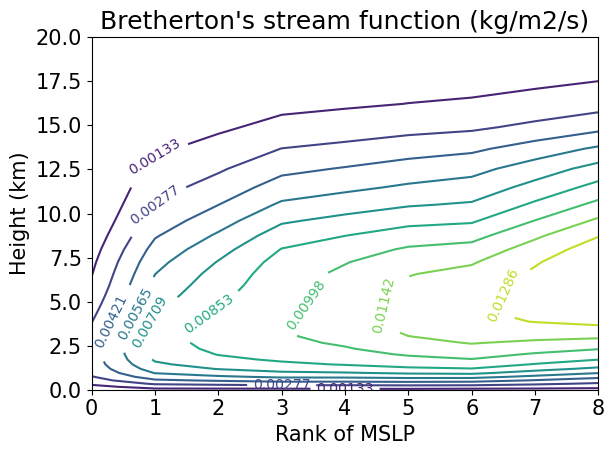

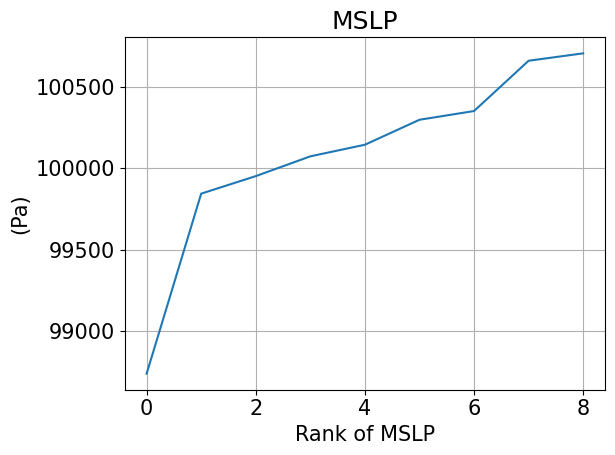

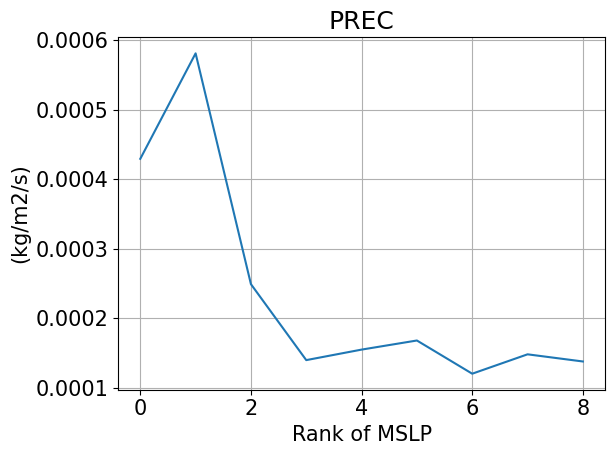

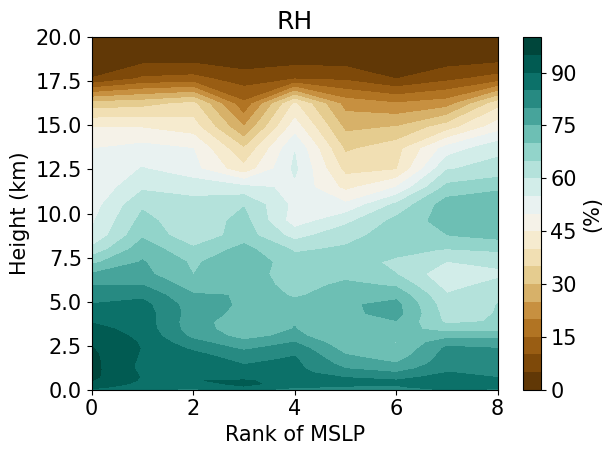

In [6]:


fig,ax=plt.subplots()
levels_psi = np.linspace(psi3dmean.min(),psi3dmean.max(),11)
CS = ax.contour(key2drank,z*1e-3,psi3dmean.T,levels=levels_psi)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_ylim(0,20)
ax.set_ylabel("Height (km)")
ax.set_xlabel(f"Rank of {key2dname}")
ax.set_title("Bretherton's stream function (kg/m2/s)")
fig.tight_layout()
if savefig:
    fig.savefig(dir_out + f"Bretherton-PSI_sortedby_{key2dname}.png")

fig,ax=plt.subplots()
#ax.plot(key2drank,key2dmean*1e-3)
ax.plot(key2drank,key2dmean)
ax.grid()
ax.set_xlabel(f"Rank of {key2dname}")
ax.set_ylabel(f"{key2dunit}")
ax.set_title(f"{key2dname}")
fig.tight_layout()
if savefig:
    fig.savefig(dir_out + f"{key2dname}_sortedby_{key2dname}.png")

fig,ax=plt.subplots()
ax.plot(key2drank,var2d1mean)
ax.grid()
ax.set_xlabel(f"Rank of {key2dname}")
ax.set_ylabel(f"{var2dunit}")
ax.set_title(f"{var2dname}")
fig.tight_layout()
if savefig:
    fig.savefig(dir_out + f"{var2dname}_sortedby_{key2dname}.png")

fig,ax=plt.subplots()
cax = ax.contourf(key2drank,z*1e-3,var3d1mean.T,levels=levels_var3d1,cmap=cmap_var3d1)
cbar = plt.colorbar(cax,ax=ax)
cbar.set_label(f"{var3dunit}")
ax.set_ylim(0,20)
ax.set_ylabel("Height (km)")
ax.set_xlabel(f"Rank of {key2dname}")
ax.set_title(f"{var3dname}")
fig.tight_layout()
if savefig:
    fig.savefig(dir_out + f"{var3dname}_sortedby_{key2dname}.png")
